In [52]:
import numpy as np
from PIL import Image
from pathlib import Path
import pandas as pd
from skimage import io
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imwrite, imsave
import matplotlib as mpl
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from matplotlib import cm
mpl.rcParams['figure.dpi'] = 200
params = {'mathtext.default': 'regular','font.family':'Helvetica' }          
plt.rcParams.update(params)

This is the second workbook where I calculate the cosine similarity for the data from brookhaven for the Ni22Cr (water experiment) and the Ni22Cr6Mo (oxidation redo) 

In [2]:
def cosine_similarity_3d(image,reference):
    """Take the cosine similarity of a hyperspectral image and a reference spectra of the same dimensions"""
    flat_image = (image.reshape((len(image),image.shape[1]*image.shape[2])).T)
    #Take the magnitude of each observation m for use in the cosine calculation
    norm = np.linalg.norm(flat_image, axis=1)
    #Calculate cosine similarity using CS = a.b/(||a||*||b||)
    cosine = np.dot(flat_image,reference)/(norm*np.linalg.norm(reference))
    #reshape the cosine sum into a 2d image
    cosine_2d = np.nan_to_num(cosine.reshape((image.shape[1],image.shape[2])),posinf=0,neginf=0)
    return cosine_2d

def cosine_similarity_2d(line,reference):
    cosine = np.dot(line,reference)/(np.linalg.norm(line)*np.linalg.norm(reference))
    return cosine

#These functions are for plotting different techniques I used in this project

def plot_pca(pca, scores, x_label,labels):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (14,10))
    axs[0,0].plot(pca.explained_variance_ratio_[:20],'bo')

    axs[0,0].set_title("Scree Plot")
    axs[0,0].set_ylabel("Cumulative Variance")
    axs[0,0].set_xlabel("Principal Component")
    axs[0,1].plot(x_label, pca.components_[0])
    axs[0,1].plot(x_label, pca.components_[1])
    axs[0,1].plot(x_label, pca.components_[2])
    axs[0,1].plot(x_label, pca.components_[3])
    axs[0,1].set_xlim((np.max(x_label),np.min(x_label)))
    axs[0,1].set_xlabel("Binding Energy (eV)")
    axs[0,1].set_ylabel("Component Loading")
    axs[0,1].set_title("Principal Components")
    axs[0,1].legend(["PC1","PC2","PC3","PC4"])

    print(scores.shape)
    axs[1,0].scatter(scores[0,:],scores[1,:], c= labels, cmap = "bwr")
    axs[1,0].set_xlabel("PC1, (" + str(round(pca.explained_variance_ratio_[0]*100,1))+"%)")
    axs[1,0].set_ylabel("PC2, (" + str(round(pca.explained_variance_ratio_[1]*100,1))+"%)")
    axs[1,1].scatter(scores[2,:],scores[3,:], c = labels, cmap = "bwr")
    axs[1,1].set_xlabel("PC3, (" + str(round(pca.explained_variance_ratio_[2]*100,1))+"%)")
    axs[1,1].set_ylabel("PC4, (" + str(round(pca.explained_variance_ratio_[3]*100,1))+"%)")

def plot_pca_combined(pca, scores, x_label, sub_label: tuple,labels):

    fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (10,15))

    axs[0,0].plot(pca.explained_variance_ratio_[:20],'bo')
    axs[0,0].set_title("Scree Plot")
    axs[0,0].set_ylabel("Cumulative Variance")
    axs[0,0].set_xlabel("Principal Component")

    axs[0,1].plot(x_label, pca.components_[0])
    axs[0,1].plot(x_label, pca.components_[1])
    axs[0,1].plot(x_label, pca.components_[2])
    axs[0,1].plot(x_label, pca.components_[3])
    axs[0,1].set_xlim((np.max(sub_label[0]),np.min(sub_label[0])))
    axs[0,1].set_xlabel("Binding Energy (eV)")
    axs[0,1].set_ylabel("Component Loading")
    axs[0,1].set_title("Principal Components")
    axs[0,1].legend(["PC1","PC2","PC3","PC4"])

    axs[1,1].plot(x_label, pca.components_[0])
    axs[1,1].plot(x_label, pca.components_[1])
    axs[1,1].plot(x_label, pca.components_[2])
    axs[1,1].plot(x_label, pca.components_[3])
    axs[1,1].set_xlim((np.max(sub_label[1]),np.min(sub_label[1])))
    axs[1,1].set_xlabel("Binding Energy (eV)")
    axs[1,1].set_ylabel("Component Loading")
    axs[1,1].set_title("Principal Components")
    axs[1,1].legend(["PC1","PC2","PC3","PC4"])

    axs[1,0].plot(x_label, pca.components_[0])
    axs[1,0].plot(x_label, pca.components_[1])
    axs[1,0].plot(x_label, pca.components_[2])
    axs[1,0].plot(x_label, pca.components_[3])
    axs[1,0].set_xlim((np.max(sub_label[2]),np.min(sub_label[2])))
    axs[1,0].set_xlabel("Binding Energy (eV)")
    axs[1,0].set_ylabel("Component Loading")
    axs[1,0].set_title("Principal Components")
    axs[1,0].legend(["PC1","PC2","PC3","PC4"])

    print(scores.shape)
    axs[2,0].scatter(scores[0,:],scores[1,:], c= labels, cmap = "bwr")
    axs[2,0].set_xlabel("PC1, (" + str(round(pca.explained_variance_ratio_[0]*100,1))+"%)")
    axs[2,0].set_ylabel("PC2, (" + str(round(pca.explained_variance_ratio_[1]*100,1))+"%)")
    axs[2,0].set_title("PC1 vs PC2")
    axs[2,1].scatter(scores[2,:],scores[3,:], c = labels, cmap = "bwr")
    axs[2,1].set_xlabel("PC3, (" + str(round(pca.explained_variance_ratio_[2]*100,1))+"%)")
    axs[2,1].set_ylabel("PC4, (" + str(round(pca.explained_variance_ratio_[3]*100,1))+"%)")
    axs[2,1].set_title("PC3 vs PC4")

def plot_ica(pca, x_label, sub_label: tuple):

    fig, axs = plt.subplots(ncols = 3, figsize = (15,5))

    axs[0].plot(x_label, pca.components_[0])
    axs[0].plot(x_label, pca.components_[1])
    axs[0].plot(x_label, pca.components_[2])
    axs[0].plot(x_label, pca.components_[3])
    # axs[0].plot(x_label, pca.components_[4])
    # axs[0].plot(x_label, pca.components_[5])
    axs[0].set_xlim((np.max(sub_label[0]),np.min(sub_label[0])))
    axs[0].set_xlabel("Binding Energy (eV)")
    axs[0].set_ylabel("Component Loading")
    axs[0].set_title("Ni 2p3/2")
    axs[0].legend(["C1","C2","C3","C4"])

    axs[1].plot(x_label, pca.components_[0])
    axs[1].plot(x_label, pca.components_[1])
    axs[1].plot(x_label, pca.components_[2])
    axs[1].plot(x_label, pca.components_[3])
    axs[1].set_xticks(np.arange(min(x_label),max(x_label),1))
    axs[1].get_yaxis().set_visible(False)
    axs[1].set_xlim((np.max(sub_label[1]),np.min(sub_label[1])))
    axs[1].set_xlabel("Binding Energy (eV)")
    #axs[1].set_ylabel("Component Loading")
    axs[1].set_title("Cr 2p3/2")
    axs[1].legend(["C1","C2","C3","C4"])

    axs[2].plot(x_label, pca.components_[0])
    axs[2].plot(x_label, pca.components_[1])
    axs[2].plot(x_label, pca.components_[2])
    axs[2].plot(x_label, pca.components_[3])
    axs[2].get_yaxis().set_visible(False)
    axs[2].set_xlim((np.max(sub_label[2]),np.min(sub_label[2])))
    axs[2].set_xlabel("Binding Energy (eV)")
    #axs[2].set_ylabel("Component Loading")
    axs[2].set_title("O 1s")
    axs[2].legend(["C1","C2","C3","C4"])
    plt.tight_layout()

In [3]:
#Read .csv files containing energy, intensity values for reference spectra
metal_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_metal_reference.csv",header=None,names=("energy","intensity"))
oxide_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_oxide_reference.csv",header=None,names=("energy","intensity"))

#Prepare data and sort (not necessary if using smooth reference spectra)
metal_ref_data = metal_ref_data.drop_duplicates(subset=["energy"])
metal_ref_data = metal_ref_data.sort_values(by=["energy"])
oxide_ref_data = oxide_ref_data.drop_duplicates(subset=["energy"])
oxide_ref_data = oxide_ref_data.sort_values(by=["energy"])

#Do cubic interpolation on the reference spectra so that any energy/step size can be made compatible with experimental spectra
metal_ref_interp = CubicSpline(metal_ref_data["energy"],metal_ref_data["intensity"])
oxide_ref_interp = CubicSpline(oxide_ref_data["energy"],oxide_ref_data["intensity"])

#Calculate a vector reference spectra with the same start, finish, and step size as the experiment
#xrange = np.arange(570,584.2,0.2)
xrange = np.arange(570,584.2,0.2)
print(len(xrange))
metal_ref = metal_ref_interp(xrange)
metal_ref = (metal_ref-min(metal_ref))/(max(metal_ref)-min(metal_ref))
oxide_ref = oxide_ref_interp(xrange)
oxide_ref = (oxide_ref-min(oxide_ref))/(max(oxide_ref)-min(oxide_ref))

72


In [4]:
#Read .csv files containing energy, intensity values for reference spectra
ni_metal_ref_data = pd.read_csv("/Users/apple/Sync/Research/XAS Reference Spectra/Ni metal xas experimental reference.csv",header=None,names=("energy","intensity"))
ni_oxide_ref_data = pd.read_csv("/Users/apple/Sync/Research/XAS Reference Spectra/Ni oxide xas experimental reference.csv",header=None,names=("energy","intensity"))

#Prepare data and sort (not necessary if using smooth reference spectra)
ni_metal_ref_data = ni_metal_ref_data.drop_duplicates(subset=["energy"])
ni_metal_ref_data = ni_metal_ref_data.sort_values(by=["energy"])
ni_oxide_ref_data = ni_oxide_ref_data.drop_duplicates(subset=["energy"])
ni_oxide_ref_data = ni_oxide_ref_data.sort_values(by=["energy"])

#Do cubic interpolation on the reference spectra so that any energy/step size can be made compatible with experimental spectra
ni_metal_ref_interp = CubicSpline(ni_metal_ref_data["energy"],ni_metal_ref_data["intensity"])
ni_oxide_ref_interp = CubicSpline(ni_oxide_ref_data["energy"],ni_oxide_ref_data["intensity"])

#Calculate a vector reference spectra with the same start, finish, and step size as the experiment
#xrange = np.arange(570,584.2,0.2)
ni_xrange = np.arange(848,865.2,0.2)
ni_metal_ref = ni_metal_ref_interp(ni_xrange)
ni_metal_ref = (ni_metal_ref-min(ni_metal_ref))/(max(ni_metal_ref)-min(ni_metal_ref))
ni_oxide_ref = ni_oxide_ref_interp(ni_xrange)
ni_oxide_ref = (ni_oxide_ref-min(ni_oxide_ref))/(max(ni_oxide_ref)-min(ni_oxide_ref))

Load the hyperspectral images for all the timesteps

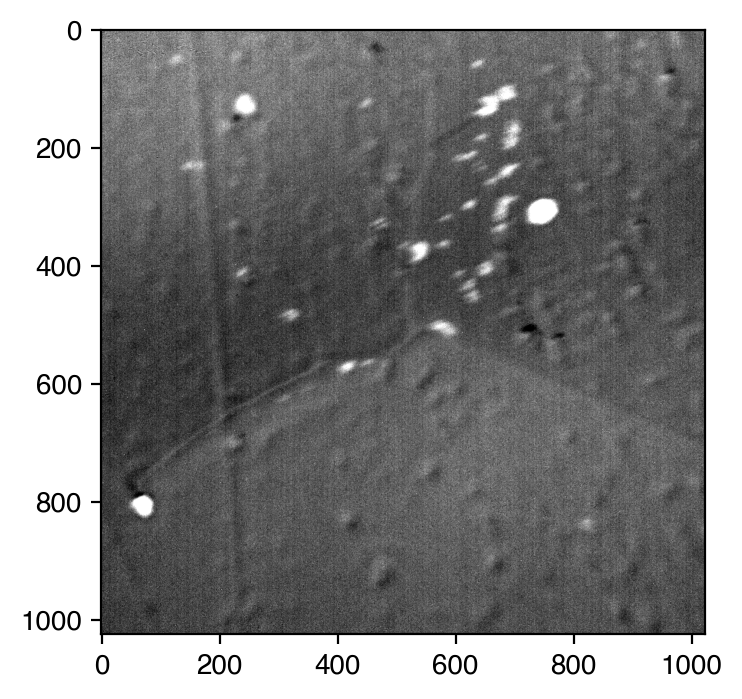

In [72]:
plt.imshow(io.imread("/Volumes/DATA STICK/6-12-24 Brookhaven XPEEM/20240612_Ni22Cr/20L_H2O/20240613_XAS_2CA_2AN_30um_576.2eV_Cr2p_200C.tif"),cmap='gray')

In [122]:
#Ni22Cr H2O exposure Cr L-edge XAS
nicr_h2o_preox = io.imread("/Volumes/DATA STICK/6-12-24 Brookhaven XPEEM/20240612_Ni22Cr/Pre-oxidation/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_RT/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_R.tif")
nicr_h2o_20L = io.imread("/Volumes/DATA STICK/6-12-24 Brookhaven XPEEM/20240612_Ni22Cr/20L_H2O/XAS_30um_2CA_2AN_570-584eV_0.2eV_step_Cr2p_200C/XAS_30um_2CA_2AN_570-584eV_0.2eV_step_CR2p_200C.tif")
nicr_h20_60L = io.imread("/Volumes/DATA STICK/6-12-24 Brookhaven XPEEM/20240612_Ni22Cr/60L_H2O/XAS_30um_2CA_2AN_570-584eV_0.2eV_step_Cr2p_200C/XAS_30um_2CA_2AN_570-584eV_0.2eV_step_Cr2p_200C.tif")

#Ni22Cr H2O exposure Ni L-edge XAS
nicr_h2o_20L_ni2p = io.imread("/Volumes/DATA STICK/6-12-24 Brookhaven XPEEM/20240612_Ni22Cr/20L_H2O/XAS_30um_2CA_2AN_884-865eV_0.2eV_step_Ni2p_200C/XAS_30um_2CA_2AN_884-865eV_0.2_eV_step_Ni2p_200C.tif")

#Ni5Cr for comparison from last year
cr5_ox2 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation2_region2.tif")

#Ni22Cr with O2 from lund for comparison
nicr_o2_65L = io.imread("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/3rd_oxidation_45L/normed_45L-Cr XAS 570-595 step0p2.tif")

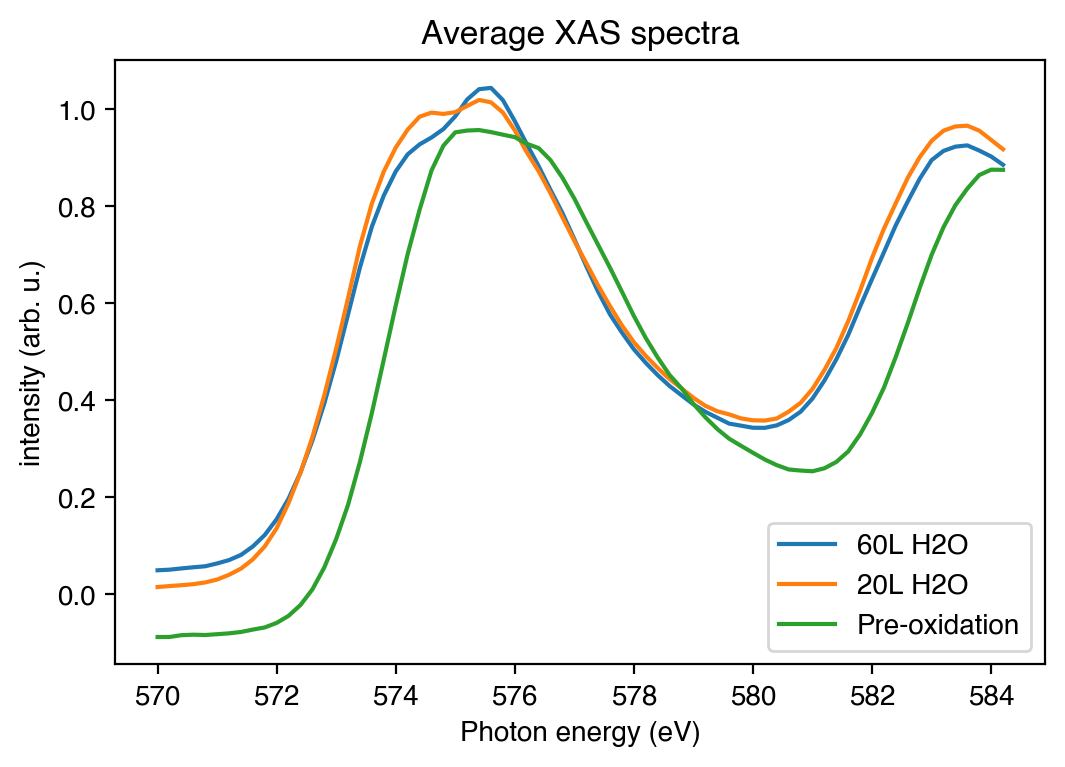

In [130]:
plt.plot(xrange, (np.average(nicr_h20_60L,axis=(1,2))-300)/1100)
plt.plot(xrange, (np.average(nicr_h2o_20L,axis=(1,2))-220)/700)
plt.plot(xrange, (np.average(nicr_h2o_preox,axis=(1,2))-180)/400)
plt.xlabel("Photon energy (eV)")
plt.ylabel("intensity (arb. u.)")
plt.title("Average XAS spectra")
plt.legend(["60L H2O","20L H2O","Pre-oxidation"])

In [131]:
flattened0 = np.reshape(nicr_h2o_preox,(nicr_h2o_preox.shape[0],nicr_h2o_preox.shape[1]**2))
flattened20 = np.reshape(nicr_h2o_20L,(nicr_h2o_preox.shape[0],nicr_h2o_preox.shape[1]**2))
flattened60 = np.reshape(nicr_h20_60L, (nicr_h2o_preox.shape[0],nicr_h2o_preox.shape[1]**2))
combined = 

In [113]:


data = nicr_h2o_20L
#load and flatten data and scale from 0-1
flattened = np.reshape(data,(data.shape[0],data.shape[1]**2)).T
print(flattened.shape)
minmax = MinMaxScaler([0,1])
normalized = minmax.fit_transform(flattened.T)
preprocessed = normalized.T

#do the PCA
cr_PCA = PCA(n_components = 10)
cr_PCA_fit = cr_PCA.fit(preprocessed)

#do the NNMA
cr_NMF = NMF(n_components = 3,max_iter=600)
cr_NMF_fit = cr_NMF.fit(preprocessed)

(1048576, 72)


/Users/apple/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 600 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [120]:
#do ICA
cr_ICA = FastICA(n_components=3)
cr_ICA_fit = cr_ICA.fit(preprocessed)

Text(0, 0.5, 'Intensity (arb. u.)')

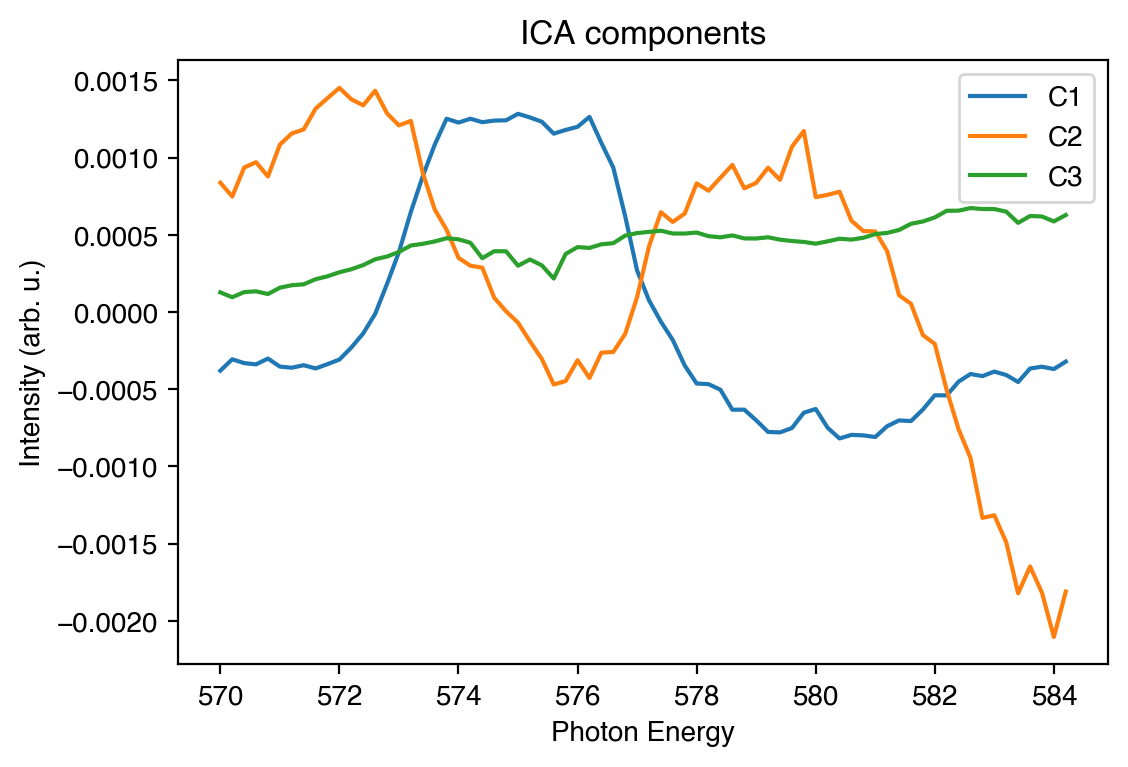

In [121]:
for i in range(3):
    plt.plot(xrange, cr_ICA_fit.components_[i])
plt.legend(["C1","C2","C3","C4"])
plt.title("ICA components")
plt.xlabel("Photon Energy")
plt.ylabel("Intensity (arb. u.)")

Text(0, 0.5, 'Cumulative variance')

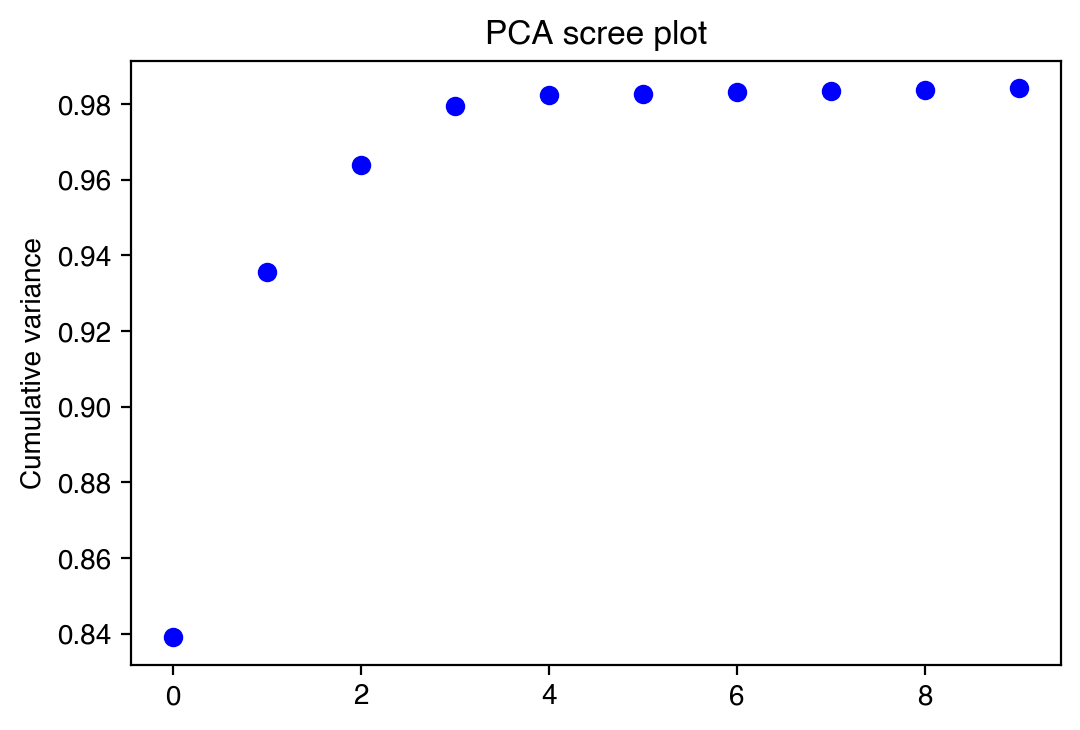

In [114]:
plt.plot(1-cr_PCA_fit.explained_variance_ratio_[:],'bo')
plt.title("PCA scree plot")
plt.ylabel("Cumulative variance")

Text(0.5, 0, 'Photon energy(eV)')

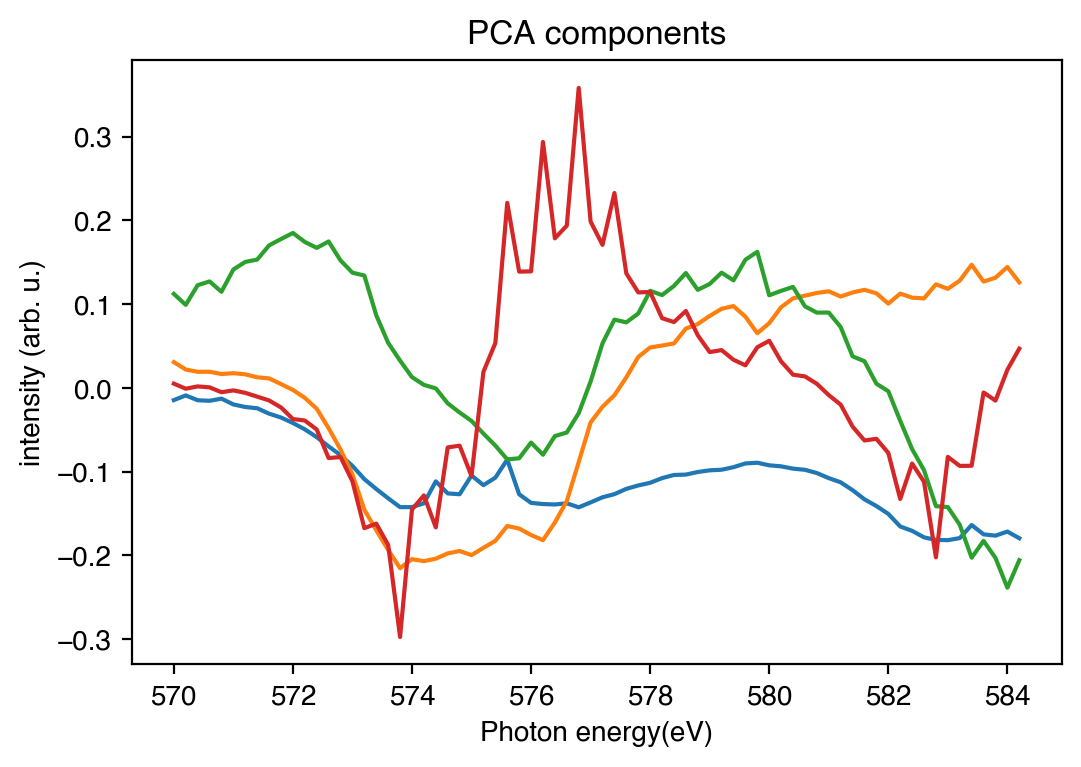

In [115]:
print()
for i in range(4):
    plt.plot(xrange, cr_PCA_fit.components_[i])
plt.title("PCA components")
plt.ylabel("intensity (arb. u.)")
plt.xlabel("Photon energy(eV)")

Text(0, 0.5, 'Intensity (arb. u.)')

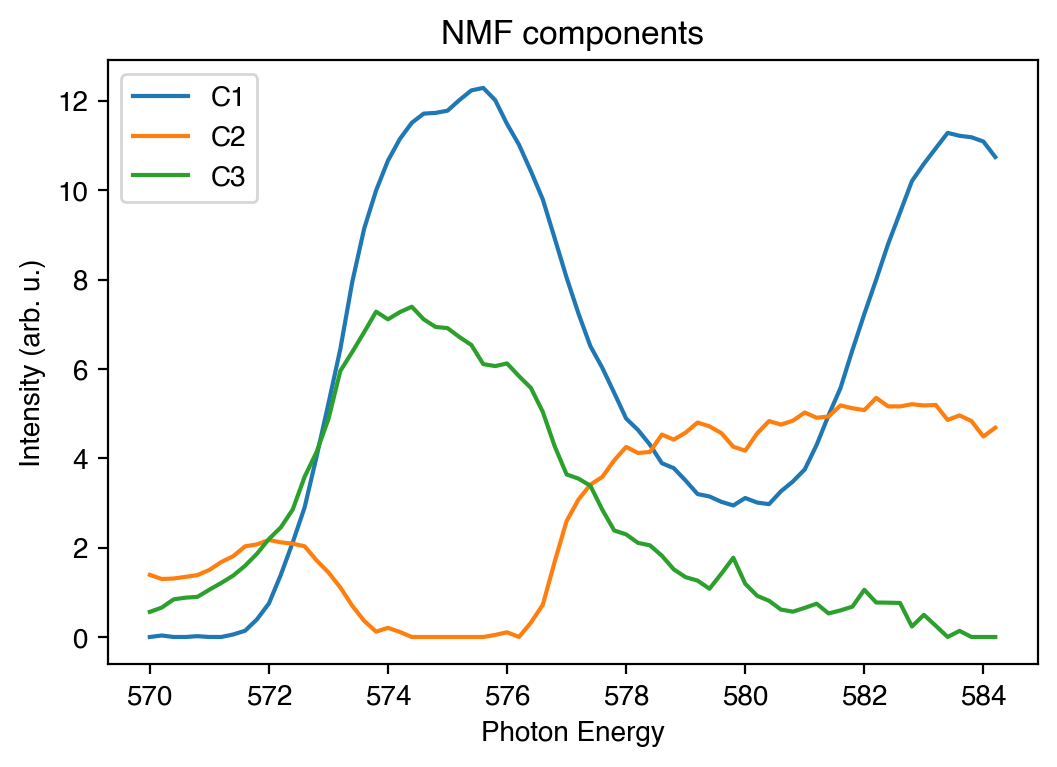

In [116]:

for i in range(3):
    plt.plot(xrange, cr_NMF_fit.components_[i])
plt.legend(["C1","C2","C3","C4"])
plt.title("NMF components")
plt.xlabel("Photon Energy")
plt.ylabel("Intensity (arb. u.)")

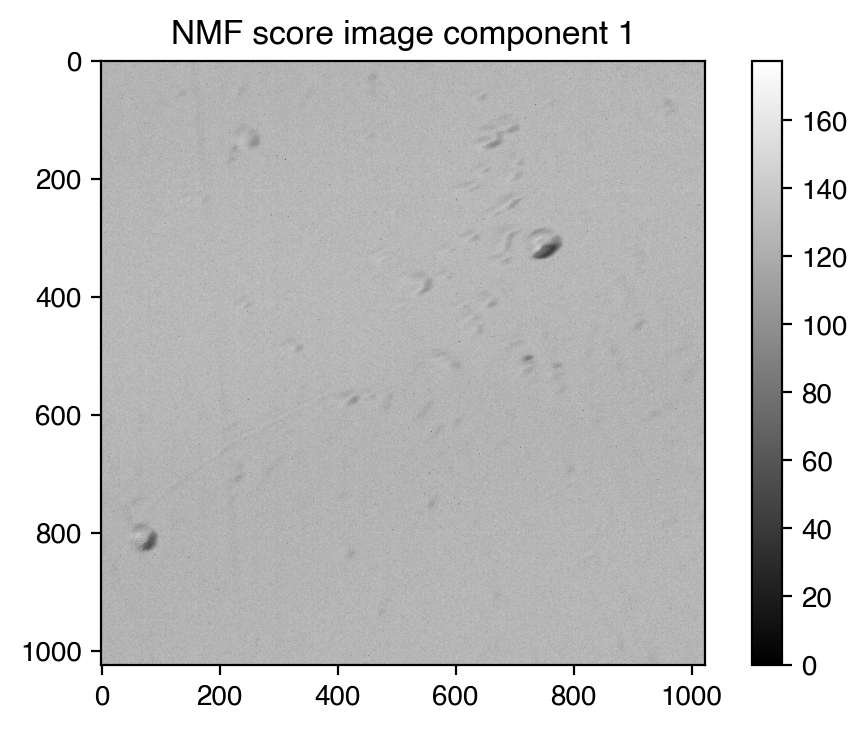

In [119]:
score_img = np.reshape(np.dot(preprocessed,cr_NMF_fit.components_[2]),(data.shape[1],data.shape[2]))
plt.imshow(score_img,cmap='gray')
plt.title("NMF score image component 1")
plt.colorbar()

In [7]:
#preoxidation XAS maps
print(nicr_h20_preox.shape)
metal_cs = cosine_similarity_3d(nicr_h20_preox[:72,:,:],metal_ref)
oxide_cs = cosine_similarity_3d(nicr_h20_preox[:72,:,:],oxide_ref)
normed_metal_cs = np.nan_to_num(metal_cs/(metal_cs+oxide_cs))
normed_oxide_cs = np.nan_to_num(oxide_cs/(metal_cs+oxide_cs))

print("metal: ", np.average(normed_metal_cs), " oxide: ", np.average(normed_oxide_cs))

NameError: name 'nicr_h20_preox' is not defined

Text(0, 0.5, 'Intensity (arb. u.)')

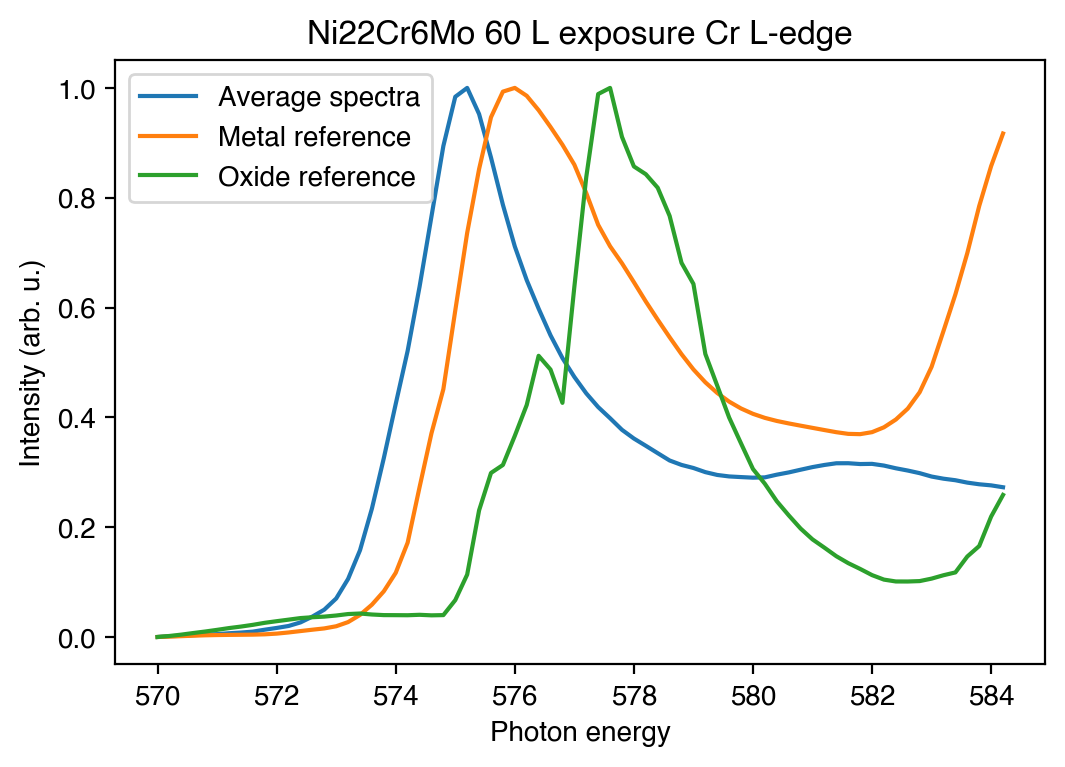

In [ ]:
avg_spectra = np.average(nicr_h20_preox[:72,:,:],axis=(1,2))
plt.plot(xrange,(avg_spectra-np.min(avg_spectra))/(np.max(avg_spectra)-np.min(avg_spectra)))
plt.plot(xrange,metal_ref)
plt.plot(xrange,oxide_ref)
plt.title("Ni22Cr6Mo 60 L exposure Cr L-edge")
plt.legend(["Average spectra","Metal reference", "Oxide reference"])
plt.xlabel("Photon energy")
plt.ylabel("Intensity (arb. u.)")

In [ ]:
plt.imshow(1-oxide_cs_to_percent(1-normed_metal_cs),cmap='gray',vmin=0,vmax=1)
#plt.imshow(normed_metal_cs,cmap='gray',vmin=np.percentile(normed_metal_cs,1),vmax=np.percentile(normed_metal_cs,99))
plt.title("Metal Cosine Similarity")
plt.colorbar()



In [ ]:
plt.imshow(oxide_cs_to_percent(normed_oxide_cs), cmap='gray',vmin=0,vmax=1)
#plt.imshow(normed_oxide_cs,cmap='gray',vmin=np.percentile(normed_oxide_cs,1),vmax=np.percentile(normed_oxide_cs,99))
plt.title("Cr L-edge Cr2O3 Linear combination concentration")
plt.colorbar()

In [ ]:
# oxide_cosine_img = 32767*np.nan_to_num(normed_oxide_cs)
# imsave("oxide_cosine_score.tif", oxide_cosine_img.astype(np.int16))

In [ ]:
# plt.violinplot(np.ndarray.flatten(oxide_cs))
# plt.violinplot(np.ndarray.flatten(metal_cs))
# #plt.legend(["Oxide", "Metal"])

Measure the similarity for Ni spectra in the Ni5Cr samples

In [ ]:
plt.imshow(normed_oxide_cs,cmap='gray',vmin=np.percentile(normed_oxide_cs,1),vmax=np.percentile(normed_oxide_cs,99))
plt.title("Ni L-edge NiO Cosine Similarity")
plt.colorbar()
oxide_cosine_img = 32767*np.nan_to_num(normed_oxide_cs)
imsave("Ni_oxide_cosine_score.tif", oxide_cosine_img.astype(np.int16))

Visualize the average spectra and spectra over time for the Ni5Cr and the Ni22Cr6Mo

In [ ]:
avg_spectra = np.average(cr5_ni_ox2,axis=(1,2))
plt.plot(ni_xrange,(avg_spectra-np.min(avg_spectra))/(np.max(avg_spectra)-np.min(avg_spectra)))
plt.plot(ni_xrange,ni_metal_ref)
plt.plot(ni_xrange,ni_oxide_ref)
#plt.title("Ni22Cr6Mo 60 L exposure Cr L-edge")
plt.legend(["Average spectra","Metal reference", "Oxide reference"])
plt.xlabel("Photon energy")
plt.ylabel("Intensity (arb. u.)")

In [ ]:
plt.plot(ni_xrange,(np.average(cr5_ni_ox2,axis=(1,2))-np.min(np.average(cr5_ni_ox2,axis=(1,2))))/(np.max(np.average(cr5_ni_ox2,axis=(1,2)))-np.min(np.average(cr5_ni_ox2,axis=(1,2)))))
plt.plot(ni_xrange,(np.average(cr5_ni_ox1,axis=(1,2))-np.min(np.average(cr5_ni_ox1,axis=(1,2))))/(np.max(np.average(cr5_ni_ox1,axis=(1,2)))-np.min(np.average(cr5_ni_ox1,axis=(1,2)))))
plt.plot(ni_xrange,(np.average(cr5_ni_preox,axis=(1,2))-np.min(np.average(cr5_ni_preox,axis=(1,2))))/(np.max(np.average(cr5_ni_preox,axis=(1,2)))-np.min(np.average(cr5_ni_preox,axis=(1,2)))))
plt.legend(["60L", "15L", "0L"])
plt.title("Ni5Cr Ni L-edge")
plt.xlabel("Photon energy (eV)")
plt.ylabel("Intensity (arb. u.)")


In [ ]:
plt.plot(ni_xrange-.7,(np.average(mo_ni_preox,axis=(1,2))-np.min(np.average(mo_ni_preox,axis=(1,2))))/(np.max(np.average(mo_ni_preox,axis=(1,2)))-np.min(np.average(mo_ni_preox,axis=(1,2)))))
plt.plot(ni_xrange,(np.average(mo_ni_ox1,axis=(1,2))-np.min(np.average(mo_ni_ox1,axis=(1,2))))/(np.max(np.average(mo_ni_ox1,axis=(1,2)))-np.min(np.average(mo_ni_ox1,axis=(1,2)))))
plt.plot(ni_xrange,(np.average(mo_ni_ox2,axis=(1,2))-np.min(np.average(mo_ni_ox2,axis=(1,2))))/(np.max(np.average(mo_ni_ox2,axis=(1,2)))-np.min(np.average(mo_ni_ox2,axis=(1,2)))))
plt.legend(["0L","20L","60L"])
plt.title("Ni22Cr6Mo Ni L-edge with artificially shifted 0L measurement")
plt.ylabel("Intensity (arb. u.)")
plt.xlabel("Photon energy (eV)")

Overlay of the Ni oxides and the Cr oxides 